## Introduction

This notebook serves to perform deeper error analysis and explore alternative solutions to previous work whereby a Naïve Bayes classifier was used to classify textual product descriptions into product categories.

## Load Data/Relevant Previous Work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

In [2]:
#load data
train_data = pd.read_csv('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-train.tsv', header=None, names=['description', 'cat_full'], sep='\t', )

#print some basic information about data
print('Number of rows: ', train_data.shape[0])
print('Number of columns: ', train_data.shape[1])

#look at the data
train_data.head()

Number of rows:  800000
Number of columns:  2


,description,cat_full
0,Replacement Viewsonic VG710 LCD Monitor 48Watt...,3292>114>1231
1,HP COMPAQ Pavilion DV6-1410EZ 4400mAh 48Wh 6 C...,3292>1370>4767>3975>1420
2,Bonjour,2296>3597>2989
3,Two Pack 6V 12Ah Eaton POWERRITE PRO II 2400 ...,3292>114>1231
4,Generations Small Side Table White,4015>3636>1319>1409>3606


In [3]:
train_data['cat_1'] = train_data['cat_full'].apply(lambda x: x.split('>')[0])
train_data['cat_2'] = train_data['cat_full'].apply(lambda x: x.split('>')[1] if (len(x.split('>'))>1) else np.nan)

In [4]:
#basic cleaning, remove any rows that don't have values in the decsription or cat_1 fields (leaving those with
#missing cat_2 for now)
print('Number of rows before cleaning: ', train_data.shape[0])
train_data.dropna(subset=['description','cat_1'], inplace=True)
print('Number of rows after cleaning: ', train_data.shape[0])

Number of rows before cleaning:  800000
Number of rows after cleaning:  800000


In [5]:
#Broadening analysis to whole training set

def quick_feature_analysis(feature=train_data['description'], tok_kwargs={}):
    vectorizer = CountVectorizer(**tok_kwargs)
    vectorizer.fit(feature)
    train_x = vectorizer.transform(feature)
    print('Number of features: ', train_x.shape[1])

    #What are some high frequency words?
    top_i = 10

    total_occurences = zip(vectorizer.get_feature_names(), train_x.sum(axis=0).tolist()[0])
    total_occurences_sorted = sorted(total_occurences, key=lambda x: -x[1])
    print(' ')
    print('Highest frequency words: ')
    print(total_occurences_sorted[0:top_i])

    print(' ')
    print('Lowest frequency words: ')
    print(total_occurences_sorted[-top_i:])

    print(' ')
    print('Basic Statistics of Word Frequencies: ')
    word_freq = train_x.sum(axis=0).tolist()[0]
    print('Mean: ', np.mean(word_freq))
    print('Standard Deviation: ', np.std(word_freq))
    print('Min: ', np.min(word_freq), ', Number of occurences: ', len(np.argwhere(word_freq==np.min(word_freq))))
    print('Max: ', np.max(word_freq))
    
quick_feature_analysis()


Number of features:  427297
 
Highest frequency words: 
[('for', 165031), ('replacement', 91313), ('pack', 74865), ('black', 64110), ('battery', 55975), ('cover', 55047), ('in', 53520), ('skin', 50501), ('and', 46959), ('decal', 43758)]
 
Lowest frequency words: 
[('µdimm', 1), ('â³', 1), ('çelebration', 1), ('égales', 1), ('élan', 1), ('épais', 1), ('étagère', 1), ('üsküdar', 1), ('œme', 1), ('ﾠb', 1)]
 
Basic Statistics of Word Frequencies: 
Mean:  19.861536589304396
Standard Deviation:  509.9616573544085
Min:  1 , Number of occurences:  290634
Max:  165031


In [6]:
test_data = pd.read_csv('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-test.tsv', header=0, names=['description', 'cat_full'], sep='\t', )
test_data['cat_1'] = test_data['cat_full'].apply(lambda x: x.split('>')[0])
test_data['cat_2'] = test_data['cat_full'].apply(lambda x: x.split('>')[1] if (len(x.split('>'))>1) else np.nan)
test_data.dropna(subset=['description','cat_1'], inplace=True)
print('Number of rows: ', test_data.shape[0])
test_data.head()


Number of rows:  200000


,description,cat_full,cat_1,cat_2
0,Sterling Silver Dangle Ball Earrings w/ Brilli...,1608>2320>2173>3813,1608,2320
1,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112...,2199>4592>12,2199,4592
2,Disc Brake Rotor-Advanced Technology Rear Rayb...,2199>4592>12,2199,4592
3,Coquette Neon Pink Ruffle Babydoll 7035 Neon P...,1608>4269>3031>1221,1608,4269
4,12V 7Ah (SPS Brand) APC NS3000RMT3U Replacemen...,3292>114>1231,3292,114


In [7]:
#test for accuracy
def display_performance(classifier, test_x, test_y, train_x=[], train_y=[]):
    """
    Prints accuracy and confusion matrix for specified classifier and test set.
    Displays the confusion matrix. 
    
    """

    if (train_x.shape[0]>0) & (train_y.shape[0]>0):
        train_accuracy = classifier.score(train_x, train_y)
        print('Overall Training Set Accuracy: ', train_accuracy)
        cv_scores = cross_val_score(classifier, train_x, train_y, cv=5)
        print('Cross-validated Training Set Accuracy: {:.2f} +/- {:.2f}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    accuracy = classifier.score(test_x, test_y)
    
    print('Test Set Accuracy: ', accuracy)
    
    predictions = classifier.predict(test_x)
    num_labels = len(classifier.classes_)
    cf_matrix = np.zeros((num_labels, num_labels))
    labels = np.unique(test_y)
    
    for i, prediction in enumerate(predictions):
        label_actual = test_y[i]
        label_actual_idx = np.argwhere(labels==label_actual)[0]
        predict_label_idx = np.argwhere(labels==prediction)[0]
        cf_matrix[label_actual_idx, predict_label_idx] += 1
        cf_matrix_norm = normalize(cf_matrix, axis=1, norm='l1')

    sns.heatmap(cf_matrix_norm, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    

Overall Training Set Accuracy:  0.880355
Cross-validated Training Set Accuracy: 0.86 +/- 0.00
Test Set Accuracy:  0.85021


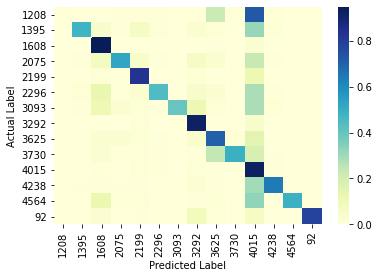

In [8]:
#setting up a pipeline to ease parameter tuning later
bayes_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(),)])
bayes_pipeline.fit(train_data['description'], train_data['cat_1'])
display_performance(bayes_pipeline.named_steps['classifier'], 
                    bayes_pipeline.named_steps['vectorizer'].transform(test_data['description']), test_data['cat_1'], 
                    bayes_pipeline.named_steps['vectorizer'].transform(train_data['description']), train_data['cat_1']
                   )

In [9]:
#grid search on a few different parameters we can tune
params = {'vectorizer__ngram_range': [(1, 1), (1, 2)],
          'vectorizer__stop_words': ('english', None),
          'vectorizer__binary': (True, False),
          'classifier__fit_prior': (True, False),
    }

grid_search = GridSearchCV(bayes_pipeline, params, cv=5, n_jobs=-1)
grid_search.fit(train_data['description'], train_data['cat_1'])
print('Best train score after grid search: ', grid_search.best_score_)
print('')
for param_name in sorted(params.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))

print('')
print('Best test score after grid search: ', grid_search.score(test_data['description'], test_data['cat_1']))

Best train score after grid search:  0.8929525

classifier__fit_prior: False
vectorizer__binary: False
vectorizer__ngram_range: (1, 2)
vectorizer__stop_words: None

Best test score after grid search:  0.8783


## Error Analysis

Here, we are looking at the performance of the first design of the text classifier found [here](/). To recap, that classifier is a multinomial Bayes classifier built on a bag of words feature model trained on 800,000 product descriptions to classify product categories. This section tries to dive deeper into where the model is failing and why.

The first thing we started to consider was the bias-variance tradeoff in this model. While it not possible to know if there is unavoidable bias in the system because we don't know the optimal accuracy (e.g. what is the best possible accuracy for human experts to categorize the products based on the provided descriptions), we hypothesized that 89.3% accuracy on the training set might be a little low. Fortunately, the accuracy drop from 89.3% on the cross-validated training set to 87.8% shows there is some variance (overfitting), but it isn't egregious. So, can we find a way to decrease bias without a larger variance bias?

During the investigation, we considered a new variable in the multinomial Bayes classifier, alpha. Alpha is the [Laplacian smoothing parameter](https://en.wikipedia.org/wiki/Additive_smoothing), which regularizes the likelihood and ensures that is is never set to zero (even if the feature for that class has never been encountered). By tuning alpha we were able to decrease bias in the system and better fit the training data, with some manageable added cost to increasing variable. Retuning the parameters also shows that decreasing alpha in concert with reintroducing 

In [10]:
#filter the points the classifier incorrectly labels of teh test set
bayes_pipeline = bayes_pipeline.set_params(**grid_search.best_params_)
bayes_pipeline.fit(train_data['description'], train_data['cat_1'])
train_data['cat_1_predict'] = bayes_pipeline.predict(train_data['description'])

bad_train_data = train_data.loc[train_data['cat_1'] != train_data['cat_1_predict']].sample(500, random_state=20)

In [11]:
#how conifdent was the classifier on correct predicitons vs incorrect predictions?
def log_loss_pipeline(this_pipeline, x):
    clf_classes = bayes_pipeline.named_steps['classifier'].classes_
    
    predictions = bayes_pipeline.predict(x)
    
    y_true = [[int(clf_classes[i]==predictions[j]) for i in range(len(clf_classes))]
                  for j in range(len(predictions))]
    
    prob_predict = bayes_pipeline.predict_proba(x)
    
    this_log_loss = log_loss(y_true, prob_predict)
    
    return this_log_loss


log_loss_correct = log_loss_pipeline(bayes_pipeline,
                                     train_data.loc[train_data['cat_1']==train_data['cat_1_predict']]['description'])

print('Log Loss for correctly classified training data: ', log_loss_correct)


log_loss_incorrect = log_loss_pipeline(bayes_pipeline,
                                       train_data.loc[train_data['cat_1']!=train_data['cat_1_predict']]['description'])

print('Log Loss for incorrectly classified training data: ', log_loss_incorrect)

Log Loss for correctly classified training data:  0.01652650022116755
Log Loss for incorrectly classified training data:  0.20875076384292474


In [12]:
bad_train_data

,description,cat_full,cat_1,cat_2,cat_1_predict
156902,Captain Layover Medium/Large 10-14 Costume,3292>3581>3145>2201,3292,3581,1608
259287,Tweeter Audiopipe 250W Super High Frequency Do...,2075>4764>272,2075,4764,3292
494083,Chip Tortla Jalapeno -Pack of 12,1208>310>397>1635>587,1208,310,4015
639196,"Wiss W10T 10"" Titanium Coated All-Purpose Scis...",92,92,NaN,4015
581963,NCAA DePaul Blue Demons Apple iPad/iPad Mini S...,3093>4104>2151,3093,4104,3292
...,...,...,...,...,...
720897,Pro Rebounder Poolside Basketball,1395>2736>3899>2657>3543,1395,2736,2075
319012,School Smart Exhibit Paper,4015>2824>2205>108,4015,2824,4238
597743,Good L Corporation GLSTeal24pk The Standard Ha...,92,92,NaN,4015
725748,DC 12V 2 Position 5 Way Neutral Electric Solen...,4564>1265>1706>159>4867>606,4564,1265,4015


In [14]:
def single_sample_eval(this_pipeline, x):
    print(x['description'])
    #print each token and the p(token|class)
    #get tokens
    tokens = this_pipeline.named_steps['vectorizer'].transform([x['description']])
    
    print('')
    
    log_prob_bad = 0
    log_prob_good = 0
    
    for token_i in tokens[0].indices:
        #print the token
        print('Token: ', this_pipeline.named_steps['vectorizer'].get_feature_names()[token_i])
        actual_label_i = np.argwhere(this_pipeline.named_steps['classifier'].classes_ == x['cat_1'])[0]
        predicted_label_i = np.argwhere(this_pipeline.named_steps['classifier'].classes_ == x['cat_1_predict'])[0]
        print('Log prob for token|actual class: ', this_pipeline.named_steps['classifier'].feature_log_prob_[actual_label_i, token_i])
        print('Log prob for token|predicted class: ', this_pipeline.named_steps['classifier'].feature_log_prob_[predicted_label_i, token_i])
        print('')
        log_prob_good += this_pipeline.named_steps['classifier'].feature_log_prob_[actual_label_i, token_i]
        log_prob_bad += this_pipeline.named_steps['classifier'].feature_log_prob_[predicted_label_i, token_i]
    
    print('Total log prob for all tokens|actual class: ', log_prob_good)
    print('Total log prob for all tokens|predicted class: ', log_prob_bad)

        
random_bad_sample = bad_train_data.iloc[4]
        
single_sample_eval(bayes_pipeline, bad_train_data.iloc[4])
    

NCAA DePaul Blue Demons Apple iPad/iPad Mini Smart Cover Case

Token:  apple
Log prob for token|actual class:  [-10.20178945]
Log prob for token|predicted class:  [-7.07493329]

Token:  apple ipad
Log prob for token|actual class:  [-10.29916362]
Log prob for token|predicted class:  [-8.74024988]

Token:  blue
Log prob for token|actual class:  [-8.8738671]
Log prob for token|predicted class:  [-7.3704168]

Token:  blue demons
Log prob for token|actual class:  [-14.08335325]
Log prob for token|predicted class:  [-15.15779882]

Token:  case
Log prob for token|actual class:  [-7.66825629]
Log prob for token|predicted class:  [-5.95670103]

Token:  cover
Log prob for token|actual class:  [-8.45393519]
Log prob for token|predicted class:  [-5.08332455]

Token:  cover case
Log prob for token|actual class:  [-10.66562657]
Log prob for token|predicted class:  [-9.65450188]

Token:  demons
Log prob for token|actual class:  [-14.08335325]
Log prob for token|predicted class:  [-14.46465164]

Token

### Removing Laplacian Smoothing

Overall Training Set Accuracy:  0.93362125
Cross-validated Training Set Accuracy: 0.85 +/- 0.00
Test Set Accuracy:  0.845305


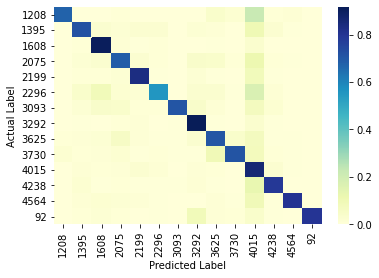

In [15]:
#setting up a pipeline to ease parameter tuning later
bayes_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(alpha=1e-10),)])
bayes_pipeline.fit(train_data['description'], train_data['cat_1'])
display_performance(bayes_pipeline.named_steps['classifier'], 
                    bayes_pipeline.named_steps['vectorizer'].transform(test_data['description']), test_data['cat_1'], 
                    bayes_pipeline.named_steps['vectorizer'].transform(train_data['description']), train_data['cat_1']
                   )

Best train score after grid search:  0.9124812499999999

classifier__fit_prior: True
vectorizer__ngram_range: (1, 2)
vectorizer__stop_words: None

Best test score after grid search:  0.88779
Overall Training Set Accuracy:  0.99584375
Cross-validated Training Set Accuracy: 0.91 +/- 0.00
Test Set Accuracy:  0.88779


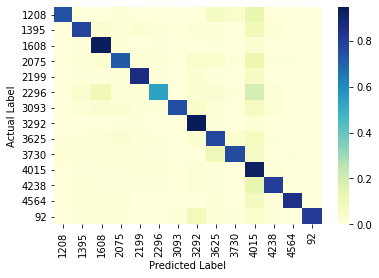

In [16]:
#redo grid search for lower alpha
params = {'vectorizer__ngram_range': [(1, 1), (1, 2)],
          'vectorizer__stop_words': ('english', None),
          'classifier__fit_prior': (True, False),
    }

grid_search = GridSearchCV(bayes_pipeline, params, cv=5, n_jobs=-1)
grid_search.fit(train_data['description'], train_data['cat_1'])
print('Best train score after grid search: ', grid_search.best_score_)
print('')
for param_name in sorted(params.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))

print('')
print('Best test score after grid search: ', grid_search.score(test_data['description'], test_data['cat_1']))
print('')


bayes_pipeline_low_alpha_optimal = bayes_pipeline.set_params(**grid_search.best_params_)
bayes_pipeline_low_alpha_optimal.fit(train_data['description'], train_data['cat_1'])
train_data['cat_1_predict'] = bayes_pipeline_low_alpha_optimal.predict(train_data['description'])

display_performance(bayes_pipeline_low_alpha_optimal.named_steps['classifier'], 
                    bayes_pipeline_low_alpha_optimal.named_steps['vectorizer'].transform(test_data['description']), test_data['cat_1'], 
                    bayes_pipeline_low_alpha_optimal.named_steps['vectorizer'].transform(train_data['description']), train_data['cat_1']
                   )

In [17]:
#redoing the same example from above and showing what changed
x = train_data.iloc[random_bad_sample.name]

print(x['description'])
#print each token and the p(token|class)
#get tokens
tokens = bayes_pipeline_low_alpha_optimal.named_steps['vectorizer'].transform([x['description']])

print('')

log_prob_bad = 0
log_prob_good = 0

for token_i in tokens[0].indices:
    #print the token
    print('Token: ', bayes_pipeline_low_alpha_optimal.named_steps['vectorizer'].get_feature_names()[token_i])
    correct_label_i = np.argwhere(bayes_pipeline_low_alpha_optimal.named_steps['classifier'].classes_ == x['cat_1'])[0]
    incorrect_label_i = np.argwhere(bayes_pipeline_low_alpha_optimal.named_steps['classifier'].classes_ == random_bad_sample['cat_1_predict'])[0]
    print('Log prob for token|incorrect class: ', bayes_pipeline_low_alpha_optimal.named_steps['classifier'].feature_log_prob_[incorrect_label_i, token_i])
    print('Log prob for token|correct class: ', bayes_pipeline_low_alpha_optimal.named_steps['classifier'].feature_log_prob_[correct_label_i, token_i])
    print('')
    log_prob_good += bayes_pipeline_low_alpha_optimal.named_steps['classifier'].feature_log_prob_[correct_label_i, token_i]
    log_prob_bad += bayes_pipeline_low_alpha_optimal.named_steps['classifier'].feature_log_prob_[incorrect_label_i, token_i]
    
print('Total log prob for all tokens|correct class: ', log_prob_good)
print('Total log prob for all tokens|incorrect class: ', log_prob_bad)
    


NCAA DePaul Blue Demons Apple iPad/iPad Mini Smart Cover Case

Token:  apple
Log prob for token|incorrect class:  [-6.68351554]
Log prob for token|correct class:  [-7.23991765]

Token:  apple ipad
Log prob for token|incorrect class:  [-8.3494944]
Log prob for token|correct class:  [-7.33835772]

Token:  blue
Log prob for token|incorrect class:  [-6.97905214]
Log prob for token|correct class:  [-5.90436849]

Token:  blue demons
Log prob for token|incorrect class:  [-15.45937386]
Log prob for token|correct class:  [-11.80426584]

Token:  case
Log prob for token|incorrect class:  [-5.56517935]
Log prob for token|correct class:  [-4.69684037]

Token:  cover
Log prob for token|incorrect class:  [-4.69177347]
Log prob for token|correct class:  [-5.48349755]

Token:  cover case
Log prob for token|incorrect class:  [-9.26496847]
Log prob for token|correct class:  [-7.70992128]

Token:  demons
Log prob for token|incorrect class:  [-14.36076157]
Log prob for token|correct class:  [-11.80426584]


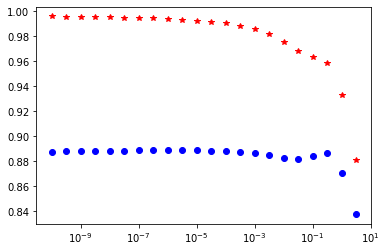

In [41]:
alphas = np.power(10.0, np.arange(-10, 1, 0.5))
training_scores = np.zeros(len(alphas))
test_scores = np.zeros(len(alphas))

for i,alpha in enumerate(alphas):

    bayes_pipeline_low_alpha_optimal.set_params(**grid_search.best_params_)
    bayes_pipeline_low_alpha_optimal.set_params(**{'classifier__alpha': alpha})
    bayes_pipeline_low_alpha_optimal.fit(train_data['description'], train_data['cat_1'])
    
    training_scores[i] = bayes_pipeline_low_alpha_optimal.score(train_data['description'], train_data['cat_1'])
    test_scores[i] = bayes_pipeline_low_alpha_optimal.score(test_data['description'], test_data['cat_1'])
    
plt.semilogx(alphas, training_scores, 'r*')
plt.semilogx(alphas, test_scores, 'bo')
plt.show()

